In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
url = '/content/drive/MyDrive/Assignment 2/'

In [4]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [5]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [6]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [7]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [8]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


# **Base Parameters**

In [9]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 180
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

16


In [10]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:972
Test dataloader:243


In [11]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 =nn.ReLU()

 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        # self.linear_5= nn.Linear(num_hidden, num_hidden)
        # self.relu_5=nn.ReLU()

 
        # self.linear_6 = nn.Linear(num_hidden, num_hidden)
        # self.relu_6 =nn.ReLU()

 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        # out  = self.linear_5(out)
        # out = self.relu_5(out)
 
        # out  = self.linear_6(out)
        # out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [12]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=180, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=180, out_features=180, bias=True)
  (relu_2): Softmax(dim=0)
  (linear_3): Linear(in_features=180, out_features=180, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=180, out_features=180, bias=True)
  (relu_4): ReLU()
  (linear_out): Linear(in_features=180, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [14]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 1.8034255504608154. Accuracy: 32.31117513891747
Epoch:  2
Iteration: 1000. Loss: 1.2328579425811768. Accuracy: 40.09055361185429
Iteration: 1500. Loss: 1.388157844543457. Accuracy: 43.218769294093434
Epoch:  3
Iteration: 2000. Loss: 1.402191162109375. Accuracy: 46.94381559991768
Iteration: 2500. Loss: 1.4702926874160767. Accuracy: 49.06359333196131
Epoch:  4
Iteration: 3000. Loss: 1.152405023574829. Accuracy: 52.13006791520889
Iteration: 3500. Loss: 1.4275457859039307. Accuracy: 56.30788228030459
Epoch:  5
Iteration: 4000. Loss: 1.0701886415481567. Accuracy: 58.28359744803458
Iteration: 4500. Loss: 1.096528172492981. Accuracy: 59.62132125951842
Epoch:  6
Iteration: 5000. Loss: 1.0761693716049194. Accuracy: 63.737394525622555
Iteration: 5500. Loss: 0.5783175230026245. Accuracy: 65.09569870343692
Epoch:  7
Iteration: 6000. Loss: 0.7824538350105286. Accuracy: 65.81601152500515
Iteration: 6500. Loss: 0.7865819334983826. Accuracy: 66.49516361391233
Epoch:  8


In [16]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Assignment 2/first_attempt.pkl')

[1.8034255504608154, 1.2328579425811768, 1.388157844543457, 1.402191162109375, 1.4702926874160767, 1.152405023574829, 1.4275457859039307, 1.0701886415481567, 1.096528172492981, 1.0761693716049194, 0.5783175230026245, 0.7824538350105286, 0.7865819334983826, 0.5796423554420471, 1.1873948574066162, 0.45773738622665405, 0.872882068157196, 0.7723417282104492, 0.7712026834487915, 0.9935771822929382, 0.884015679359436, 0.5590435266494751, 0.7782706618309021, 0.46351751685142517, 0.2819603383541107, 0.4145631194114685, 0.7702907919883728, 0.4588976800441742, 0.44361239671707153, 0.5781755447387695, 0.5903805494308472]


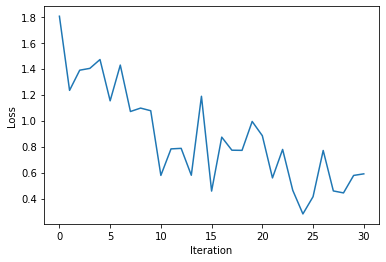

In [15]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()